In [51]:
import torch
import sys
sys.path.append('/Users/leongugel/PycharmProjects/spectral-phase-retrieval')
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import random
from torchvision import transforms
import math 
import matplotlib.pyplot as plt
from scipy.fft import fft, rfft, irfft, ifft,fftshift, fft2, ifft2, dct, idct
from scipy.ndimage.filters import gaussian_filter
from PIL import Image, ImageCms
from torch.utils.data.sampler import Sampler
from models.seq_blocks import MlpNet


In [4]:
def fft_magitude(img, shift: bool=True):
    if isinstance(img, np.ndarray):
        img_tensor = torch.from_numpy(img)
    else:
        img_tensor = img
    fft_img = torch.fft.fft2(img_tensor, norm="forward")
    fft_img_magnitude = torch.abs(fft_img)
    if shift:
        fft_img_magnitude = torch.fft.fftshift(fft_img_magnitude)
    return fft_img_magnitude

In [5]:
def pol2cart(r, phi):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return(x, y)

In [6]:
def get_random_spike_signals_polar(n_spikes: int = 1, 
                                   img_size: int = 32, 
                                   min_dist: int = 4, 
                                   sigma: float = 1.0, 
                                   add_gauss_noise: float = 0.0125) -> torch.Tensor:
    phi_ranges = 2*np.pi*np.arange(0, n_spikes, 1)/n_spikes
    half_size = img_size // 2
    r_ranges =( np.random.permutation(half_size-2*min_dist)+min_dist)[:n_spikes]
    x, y = pol2cart(r_ranges, phi_ranges)
    x += (half_size)
    y += (half_size)
    x = np.int32(np.round(x))
    y = np.int32(np.round(y))
    img_spikes = np.zeros((img_size, img_size))
    for ind in range(n_spikes):
        img_spikes[y[ind], x[ind]] =1.0
    if sigma > 0: 
        img_spikes = gaussian_filter(img_spikes, sigma)
    img_spikes = torch.from_numpy(img_spikes)
    if add_gauss_noise > 0.0:
        img_spikes = img_spikes + add_gauss_noise*torch.randn_like(img_spikes)
    
    return img_spikes, x, y

In [36]:

class SpikesSampler(Sampler):
    def __init__(self,
                 batch_size: int = 4,
                 spikes_range=(3, 16),
                 img_size: int = 32,
                 min_dist: int = 4,
                 sigma: float = 1.0,
                 add_gauss_noise: float = 0.0125,
                 len_ds: int = 10000):
        'Initialization'
        self.batch_size = batch_size
        self.spikes_range = spikes_range
        self.img_size = img_size
        self.min_dist = min_dist
        self.sigma = sigma
        self.add_gauss_noise = add_gauss_noise
        self.len_ds = len_ds

    def __len__(self):
        'Denotes the total number of samples'
        raise int(self.len_ds)

    def _get_item(self):
        'Generates one sample of data'
        # Select sample
        n_spikes = np.random.randint(self.spikes_range[0], self.spikes_range[1])

        # Load data and get label
        # print(f'n_spikes:{n_spikes}, self.img_size: {self.img_size}')
        img_spikes, x, y = get_random_spike_signals_polar(n_spikes=n_spikes,
                                                          img_size=self.img_size,
                                                          min_dist=self.min_dist,
                                                          sigma=self.sigma,
                                                          add_gauss_noise=self.add_gauss_noise)
        fft_spkes = fft_magitude(img_spikes)

        return fft_spkes, img_spikes, n_spikes, x, y

    def __iter__(self):
        batch = {'fft_spikes': [], 'img_spikes': [], 'n_spikes': [], 'x': [], 'y': []}
        for _ in range(self.batch_size):
            fft_spkes, img_spikes, n_spikes, x, y = self._get_item()
            batch['fft_spikes'].append(fft_spkes)
            batch['img_spikes'].append(img_spikes)
            batch['n_spikes'].append(n_spikes)
            batch['x'].append(x)
            batch['y'].append(y)
        batch['fft_spikes'] = torch.stack(batch['fft_spikes'])
        batch['n_spikes'] = torch.tensor(batch['n_spikes'])[:, None]
        yield batch


In [23]:
class SpikesDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 spikes_range = [3, 16],
                 img_size: int = 32, 
                 min_dist: int = 4, 
                 sigma: float = 1.0, 
                 add_gauss_noise: float = 0.0125,
                  len_ds: int = 10000):
        'Initialization'
        self.spikes_range=spikes_range
        self.img_size = img_size
        self.min_dist = min_dist
        self.sigma = sigma
        self.add_gauss_noise = add_gauss_noise 
        self.len_ds =len_ds

    def __len__(self):
            'Denotes the total number of samples'
            raise int(self.len_ds)

    def __getitem__(self, index):
            'Generates one sample of data'
            # Select sample
            n_spikes = np.random.randint(spikes_range[0],spikes_range[1])

            # Load data and get label
            img_spikes, x, y = get_random_spike_signals_polar(n_spikes=n_spikes, 
                                   img_size = self.img_size, 
                                   min_dist = self.min_dist, 
                                   sigma =  self.sigma, 
                                   add_gauss_noise = self.add_gauss_noise)
            fft_spkes = fft_magitude(img_spikes)

            return fft_spkes, img_spikes, n_spikes, x, y

In [31]:
np.random.randint(2,10)

3

In [33]:
# Parameters
params = {'batch_size': 8,
          'num_workers': 4}
spikes_ds = SpikesDataset(len_ds = 10)
training_generator = torch.utils.data.DataLoader(spikes_ds, **params)


In [87]:
img_size = 32
batch_size = 16
spikes_range=(2, 8)
n_classes = spikes_range[1] - spikes_range[0] +1
spike_sampler = SpikesSampler(spikes_range=spikes_range, 
                              img_size=img_size,
                              batch_size=batch_size, 
                              add_gauss_noise = 0.0)
batch_spikes_data = next(iter(spike_sampler))

In [88]:
n_classes

7

In [63]:
in_size = img_size**2
ch_list = [in_size, in_size // 4, in_size // 16, in_size // 32, in_size // 128, in_size // 256, 1]
mlp_net = MlpNet(in_ch=in_size,
                 ch_list = ch_list,
                  out_ch=1,
                 deep=len(ch_list),
                  multy_coeff=0.5)

In [64]:
mlp_net

MlpNet(
  (fc_layers): BlockList(
    (0): FcBlock(
      (fc_seq): BlockList(
        (0): Linear(in_features=1024, out_features=256, bias=True)
        (1): Identity()
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (1): FcBlock(
      (fc_seq): BlockList(
        (0): Linear(in_features=256, out_features=64, bias=True)
        (1): Identity()
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (2): FcBlock(
      (fc_seq): BlockList(
        (0): Linear(in_features=64, out_features=32, bias=True)
        (1): Identity()
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (3): FcBlock(
      (fc_seq): BlockList(
        (0): Linear(in_features=32, out_features=8, bias=True)
        (1): Identity()
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (4): FcBlock(
      (fc_seq): BlockList(
        (0): Linear(in_features=8, out_features=4, bias=True)
        (1): Identity()
        (2): Lea

In [65]:
iters = 10000
mlp_net.train()
l2_loss = torch.nn.MSELoss()
class_loss = torch.nn.CrossEntropyLoss
optim = torch.optim.Adam(params=mlp_net.parameters(), lr= 0.00001)

In [ ]:
x = torch.flatten(batch_spikes_data['fft_spikes'], 1).to(torch.float)
y = batch_spikes_data['n_spikes'].to(torch.float)
y_pred = mlp_net(x)

In [75]:
y

tensor([[7.],
        [4.],
        [7.],
        [3.],
        [2.],
        [2.],
        [6.],
        [5.],
        [5.],
        [6.],
        [4.],
        [6.],
        [3.],
        [3.],
        [6.],
        [3.]])

In [76]:
y_pred

tensor([[7.6327],
        [3.6515],
        [7.6117],
        [2.8587],
        [0.8750],
        [1.4614],
        [6.2523],
        [5.1917],
        [5.3948],
        [6.1696],
        [3.5093],
        [6.3213],
        [2.9187],
        [2.7440],
        [6.5029],
        [2.8569]], grad_fn=<LeakyReluBackward1>)

In [72]:
l2_loss_pred = []
for ind in range(iters):
    batch_spikes_data = next(iter(spike_sampler))
    x = torch.flatten(batch_spikes_data['fft_spikes'], 1).to(torch.float)
    y = batch_spikes_data['n_spikes'].to(torch.float)
    y_pred = mlp_net(x)
    pred_loss = l2_loss(y, y_pred)
    pred_loss.backward()
    optim.step()
    l2_loss_pred.append(pred_loss.detach().cpu().numpy())
    if ind % 500 ==0:
        print(f'ind: {ind}, loss: {pred_loss}')
l2_loss_pred=np.array(l2_loss_pred)

ind: 0, loss: 3.7030858993530273
ind: 500, loss: 3.004824638366699
ind: 1000, loss: 3.096035957336426
ind: 1500, loss: 2.843257427215576
ind: 2000, loss: 1.5155291557312012
ind: 2500, loss: 1.6146228313446045
ind: 3000, loss: 1.7886306047439575
ind: 3500, loss: 1.6603196859359741
ind: 4000, loss: 2.0471994876861572
ind: 4500, loss: 1.7338281869888306
ind: 5000, loss: 0.8767526149749756
ind: 5500, loss: 1.363584041595459
ind: 6000, loss: 0.6734015941619873
ind: 6500, loss: 0.8365642428398132
ind: 7000, loss: 0.5023687481880188
ind: 7500, loss: 0.25611451268196106
ind: 8000, loss: 0.2980993390083313
ind: 8500, loss: 0.06660129874944687
ind: 9000, loss: 0.07051374018192291
ind: 9500, loss: 0.2875252664089203


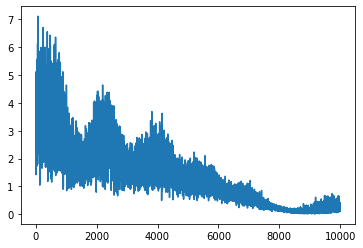

In [74]:

plt.plot(l2_loss_pred)

In [105]:
class PikesClaseesNet(nn.Module):
    def __init__(self,in_size,ch_list, n_classes):
        super(PikesClaseesNet, self).__init__()
        ch_list =  ch_list + [n_classes]
        self.mlp_net = MlpNet(in_ch=in_size,
                     ch_list = ch_list,
                      out_ch=n_classes,
                     deep=len(ch_list),
                      multy_coeff=0.5)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        out_net = self.mlp_net(x)
        return self.sigmoid (out_net)

In [106]:
ch_list = [in_size, in_size // 4, in_size // 8, in_size //16, in_size // 32, in_size // 64]
# mlp_net = MlpNet(in_ch=in_size,
#                  ch_list = ch_list,
#                   out_ch=1,
#                  deep=len(ch_list),
#                   multy_coeff=0.5)

In [107]:
ch_list, ch_list + [n_classes]

([1024, 256, 128, 64, 32, 16], [1024, 256, 128, 64, 32, 16, 7])

In [108]:
pikes_classes_net = PikesClaseesNet(in_size=in_size, ch_list = ch_list, n_classes=n_classes)

In [109]:
pikes_classes_net.mlp_net

MlpNet(
  (fc_layers): BlockList(
    (0): FcBlock(
      (fc_seq): BlockList(
        (0): Linear(in_features=1024, out_features=256, bias=True)
        (1): Identity()
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (1): FcBlock(
      (fc_seq): BlockList(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): Identity()
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (2): FcBlock(
      (fc_seq): BlockList(
        (0): Linear(in_features=128, out_features=64, bias=True)
        (1): Identity()
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (3): FcBlock(
      (fc_seq): BlockList(
        (0): Linear(in_features=64, out_features=32, bias=True)
        (1): Identity()
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (4): FcBlock(
      (fc_seq): BlockList(
        (0): Linear(in_features=32, out_features=16, bias=True)
        (1): Identity()
        (2)

In [119]:
x = torch.flatten(batch_spikes_data['fft_spikes'], 1).to(torch.float)
y = batch_spikes_data['n_spikes'].to(torch.long)
y_pred = pikes_classes_net(x)

In [120]:
y_pred

tensor([[0.4994, 0.5375, 0.4893, 0.5345, 0.4926, 0.5745, 0.5070],
        [0.4994, 0.5375, 0.4893, 0.5345, 0.4926, 0.5745, 0.5070],
        [0.4994, 0.5375, 0.4893, 0.5345, 0.4926, 0.5745, 0.5070],
        [0.4994, 0.5375, 0.4893, 0.5345, 0.4926, 0.5745, 0.5070],
        [0.4994, 0.5375, 0.4893, 0.5345, 0.4926, 0.5745, 0.5070],
        [0.4994, 0.5375, 0.4893, 0.5345, 0.4926, 0.5745, 0.5070],
        [0.4994, 0.5375, 0.4893, 0.5345, 0.4926, 0.5745, 0.5070],
        [0.4994, 0.5375, 0.4893, 0.5345, 0.4926, 0.5745, 0.5070],
        [0.4994, 0.5375, 0.4893, 0.5345, 0.4926, 0.5745, 0.5070],
        [0.4994, 0.5375, 0.4893, 0.5345, 0.4926, 0.5745, 0.5070],
        [0.4994, 0.5375, 0.4893, 0.5345, 0.4926, 0.5745, 0.5070],
        [0.4994, 0.5375, 0.4893, 0.5345, 0.4926, 0.5745, 0.5070],
        [0.4994, 0.5375, 0.4893, 0.5345, 0.4926, 0.5745, 0.5070],
        [0.4994, 0.5375, 0.4893, 0.5345, 0.4926, 0.5745, 0.5070],
        [0.4994, 0.5375, 0.4893, 0.5345, 0.4926, 0.5745, 0.5070],
        [0

In [121]:
torch.nn.functional.one_hot(y, num_classes=7)

RuntimeError: Class values must be smaller than num_classes.

In [124]:
y, n_classes

(tensor([[6],
         [5],
         [7],
         [2],
         [6],
         [2],
         [6],
         [2],
         [6],
         [3],
         [4],
         [3],
         [6],
         [6],
         [5],
         [7]]),
 7)